#IC-SHM Component Recognition Model
Run the following cells till the first checkpoint for training

In [ ]:
#Importing the necessary libraries
import platform
print("Python version:", platform.python_version())

import sys
import os

import tensorflow as tf
print("tensorflow version:",tf.__version__)

import numpy as np
print("numpy version:",np.__version__)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
print("matplotlib version:",matplotlib.__version__)

import pandas as pd
print("pandas version:",pd.__version__)

from skimage.transform import resize

from tensorflow.keras import datasets, layers, models

Python version: 3.7.13
tensorflow version: 2.8.2
numpy version: 1.21.6
matplotlib version: 3.2.2
pandas version: 1.3.5


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#Monting G-Drive to access the datasets
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#Function to change the path format 
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path

In [ ]:
# Function to put the label images into 7 channels

def get_label(file_path):

    mask = np.squeeze(file_path, axis = 2)

    target_array = np.zeros((mask.shape[0],mask.shape[1],7))
    target_array[:,:,0]=np.where(mask == 1, 1, 0)
    target_array[:,:,1]=np.where(mask == 2, 1, 0)
    target_array[:,:,2]=np.where(mask == 3, 1, 0)
    target_array[:,:,3]=np.where(mask == 4, 1, 0)
    target_array[:,:,4]=np.where(mask == 5, 1, 0)
    target_array[:,:,5]=np.where(mask == 6, 1, 0)
    target_array[:,:,6]=np.where(mask == 7, 1, 0)

    return target_array

In [ ]:
# Function to normalize the images
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [ ]:
# Functions to plot the images and labels
def show_img(image):
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

def show_label(label):
  fig, axes = plt.subplots(1, 7, figsize=(16, 112))
  y = label.numpy()
  axes[0].axis('off')
  axes[1].axis('off')
  axes[2].axis('off')
  axes[3].axis('off')
  axes[4].axis('off')
  axes[5].axis('off')
  axes[6].axis('off')
  y1 = y[:,:,0]
  y2 = y[:,:,1]
  y3 = y[:,:,2]
  y4 = y[:,:,3]
  y5 = y[:,:,4]
  y6 = y[:,:,5]
  y7 = y[:,:,6]
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)
  axes[3].imshow(y4)
  axes[4].imshow(y5)
  axes[5].imshow(y6)
  axes[6].imshow(y7)

In [ ]:
# Function to print the prediction images
def show_pred(y):
  fig, axes = plt.subplots(1, 7, figsize=(16, 112))
  y1 = y[:,:,0]
  y2 = y[:,:,1]
  y3 = y[:,:,2]
  y4 = y[:,:,3]
  y5 = y[:,:,4]
  y6 = y[:,:,5]
  y7 = y[:,:,6]
  axes[0].axis('off')
  axes[1].axis('off')
  axes[2].axis('off')
  axes[3].axis('off')
  axes[4].axis('off')
  axes[5].axis('off')
  axes[6].axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)
  axes[3].imshow(y4)
  axes[4].imshow(y5)
  axes[5].imshow(y6)
  axes[6].imshow(y7)

###Checkpoint - 1
Run untill here for training and testing alike.

In [ ]:
# Image and Label augmentation function 
# Uncomment the second line when cropping needed

def image_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  #img = tf.image.stateless_random_crop(value = img, size = (192, 320, 3), seed = seed, name=None) 
  return img

def label_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  #img = tf.image.stateless_random_crop(value = img, size = (192, 320, 7), seed = seed, name=None) 
  return img

In [ ]:
# Tensorflow data pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)        #Prefetching the data form improved speed 
    dataset = dataset.shuffle(buffer_size=5000)    
    dataset = dataset.map(preprocess, num_parallel_calls= tf.data.AUTOTUNE) 
    dataset = dataset.batch(batch, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset

In [ ]:
# Preprocess function to run all the required preprocessing functions on the images
def preprocess(x, y):
    def f(x, y):
        x = tf.io.read_file(x)
        y = tf.io.read_file(y)
        x = tf.io.decode_png(x, channels = 0)
        x = tf.image.resize(x, [360,640])
        x = tf.numpy_function(normalize, [x], [tf.float32])
        y = tf.io.decode_bmp(y, channels = 0)
        y = tf.numpy_function(get_label, [y], [tf.float32])
        y = tf.image.resize(y, [360,640])
        x = tf.image.resize_with_pad(x, 192, 320)       #Comment this line out when cropping in augmentation
        y = tf.image.resize_with_pad(y, 192, 320)       #Comment this line out when cropping in augmentation
        x = tf.numpy_function(image_augmentation, [x], [tf.float32])
        y = tf.numpy_function(label_augmentation, [y], [tf.float32])
        
        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([192, 320, 3])
    masks.set_shape([192, 320, 7])

    return images, masks

In [ ]:
#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('/content/drive/MyDrive/IC-SHM 2021','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]

In [ ]:
#training and validation split
train1 = train_comp[:1200]
val1 = train_comp[3000:4200]

In [ ]:
# Creating the tf dataset from dataframe containing image addresses
images = train1['image file name'].to_numpy()
masks = train1['component label file name'].to_numpy()
dataset = tf_dataset(images, masks)
images_val = val1['image file name'].to_numpy( )
masks_val = val1['component label file name'].to_numpy()
dataset_val = tf_dataset(images_val, masks_val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


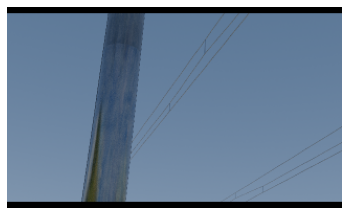

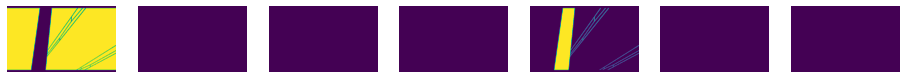

In [ ]:
#Printing out an image for reference
for x, y in dataset.take(1):
        show_img(x[0])
        show_label(y[0])
        break

###Checkpoint - 2

In [ ]:
#Importing the necessary Keras libraries for Creating a Model
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Add, ZeroPadding2D
from keras.models import Model
from keras.layers.convolutional import UpSampling2D

In [ ]:
# Inception Module
def inception_block(inputs, num_filters=32):
  x = Conv2D(num_filters, 1, padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x1 = Conv2D(num_filters, 1, padding="same")(inputs)
  x1 = BatchNormalization()(x1)
  x1 = Activation("relu")(x1)
  x1 = Conv2D(num_filters, 3, padding="same")(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation("relu")(x1)

  x2 = Conv2D(num_filters, 1, padding="same")(inputs)
  x2 = BatchNormalization()(x2)
  x2 = Activation("relu")(x2)
  x2 = Conv2D(num_filters, (3,1), padding="same")(x2)
  x2 = Conv2D(num_filters, (1,3), padding="same")(x2)
  x2 = BatchNormalization()(x2)
  x2 = Activation("relu")(x2)

  x3 = MaxPool2D((3,3), strides=(1,1), padding="same")(inputs)
  x3 = Conv2D(num_filters, 1, padding="same")(x3)
  x3 = BatchNormalization()(x3)
  x3 = Activation("relu")(x3)

  inception_module = Concatenate(axis=3)([x, x1, x2, x3])
  
  return inception_module


# encoder block
def encoder_block(input, num_filters):
  x = inception_block(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

def conv_block1(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Decoder blocks for unet2
def decoder_block1(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block1(x, num_filters)
    return x

# decoder block
def decoder_block(input, skip_features, num_filters):
  x = UpSampling2D(size=(2,2))(input)
  x = inception_block(x, num_filters)
  x = Concatenate(axis=3)([x, skip_features])
  return x

# build inception u-net
def build_inception_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  # s4, p4 = encoder_block(p3, 512)

  s4 = inception_block(p3, 512)
  # s5 = inception_block(p4, 1024)

  # d1 = decoder_block(s5, s4, 512)
  d2 = decoder_block1(s4, s3, 256)
  d3 = decoder_block1(d2, s2, 128)
  d4 = decoder_block1(d3, s1, 64)

  outputs = Conv2D(7, 1, padding="same", activation="sigmoid")(d4)

  model = Model(inputs, outputs, name="Inception_UNet")
  return model

In [ ]:
input_shape = (192, 320, 3)
# model = build_unet(input_shape)
model = build_inception_unet(input_shape)
model.summary()

Model: "Inception_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 192, 320, 64  256         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_79 (Conv2D)             (None, 192, 320, 64  256         ['input_3[0][0]']                
                                )                                                    




###Checkpoint 3

In [ ]:
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [ ]:
ck_path = os.path.join('/content/drive/MyDrive/summer_intern','Checkpoints')
checkpoint_path = os.path.join(ck_path, "my_checkpoint.ckpt") #Change the checkpoint path  
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
''' Courtesy stackoverflow Daniel Möller https://stackoverflow.com/users/2097240/daniel-m%c3%b6ller?tab=profile
answer to question "Custom loss function for U-net in keras using class weights: `class_weight` not supported for 3+ dimensional targets'''
# Weighted loss function  
from keras import backend as K
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [ ]:
# The weights for each class are hardcoded here and are calculated using the code presented towards the end of this notebook
weights=[(12.271834261551124/53.876072549963204),(12.271834261551124/12.765564322057187),(12.271834261551124/12.271834261551124),(12.271834261551124/17.37891736569488),(12.271834261551124/2.8669312087458843),(12.271834261551124/0.6609945109094115),(12.271834261551124/0.1793254950495065)]

In [ ]:
#Compiling the model
model.compile(optimizer= optimizer_adam,
              loss= weightedLoss(tf.keras.losses.BinaryCrossentropy(), weights),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(thresholds = 0.4), #Threshold value is changed from 0.5 to for higher probabilistic predictions
                       tf.keras.metrics.Precision(thresholds = 0.7),
                       tf.keras.metrics.MeanIoU(7)])

In [ ]:
#Loading checkpoint weights
# model.load_weights(checkpoint_path)

###Checkpoint 4

In [ ]:
#Train the model
history = model.fit(dataset, epochs=10,validation_data= dataset_val, verbose = 1, callbacks = cp_callback, use_multiprocessing = True)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.4932 - binary_accuracy: 0.7626 - recall_1: 0.6469 - precision_1: 0.3800 - mean_io_u_1: 0.4339
Epoch 1: saving model to /content/drive/MyDrive/summer_intern/Checkpoints/my_checkpoint.ckpt
150/150 [==============================] - 1820s 12s/step - loss: 0.4932 - binary_accuracy: 0.7626 - recall_1: 0.6469 - precision_1: 0.3800 - mean_io_u_1: 0.4339 - val_loss: 0.4387 - val_binary_accuracy: 0.7670 - val_recall_1: 0.4844 - val_precision_1: 0.2997 - val_mean_io_u_1: 0.4339
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.3615 - binary_accuracy: 0.8724 - recall_1: 0.6587 - precision_1: 0.8369 - mean_io_u_1: 0.4339
Epoch 2: saving model to /content/drive/MyDrive/summer_intern/Checkpoints/my_checkpoint.ckpt
150/150 [==============================] - 236s 2s/step - loss: 0.3615 - binary_accuracy: 0.8724 - recall_1: 0.6587 - precision_1: 0.8369 - mean_io_u_1: 0.4339 - val_loss: 0.3424 - val_binary_accu

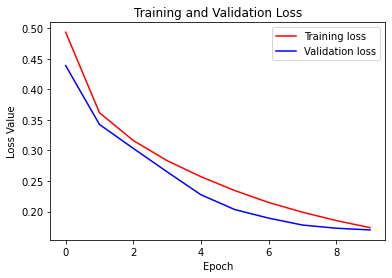

In [ ]:
#Print Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

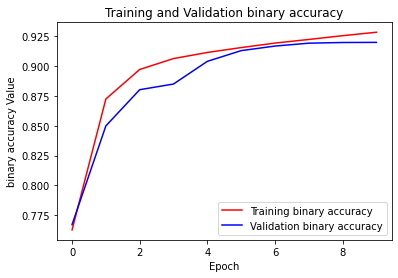

In [ ]:
#Print Binary Accuracy
accu = history.history['binary_accuracy']
val_accu = history.history['val_binary_accuracy']

plt.figure()
plt.plot(history.epoch, accu, 'r', label='Training binary accuracy')
plt.plot(history.epoch, val_accu, 'b', label='Validation binary accuracy')
plt.title('Training and Validation binary accuracy')
plt.xlabel('Epoch')
plt.ylabel('binary accuracy Value')
plt.legend()
plt.show()

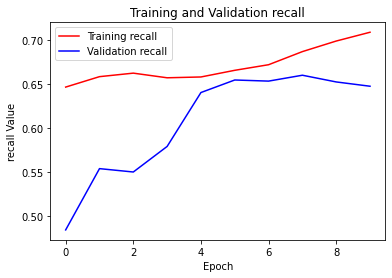

In [ ]:
#print recall
recall = history.history['recall_1']
val_recall = history.history['val_recall_1']

plt.figure()
plt.plot(history.epoch, recall, 'r', label='Training recall')
plt.plot(history.epoch, val_recall, 'b', label='Validation recall')
plt.title('Training and Validation recall')
plt.xlabel('Epoch')
plt.ylabel('recall Value')
plt.legend()
plt.show()

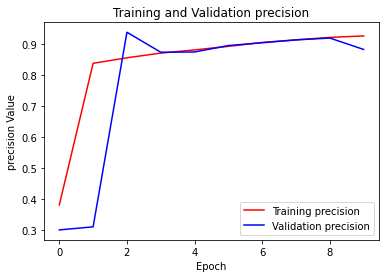

In [ ]:
#Print precision
pres = history.history['precision_1']
val_pres = history.history['val_precision_1']

plt.figure()
plt.plot(history.epoch, pres, 'r', label='Training precision')
plt.plot(history.epoch, val_pres, 'b', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision Value')
plt.legend()
plt.show()

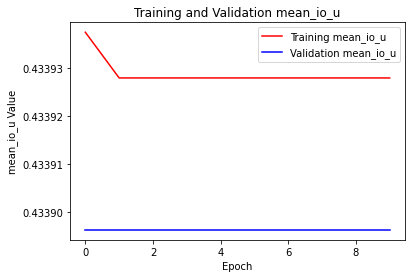

In [ ]:
#Print Mean IoU
miou = history.history['mean_io_u_1']
val_miou = history.history['val_mean_io_u_1']

plt.figure()
plt.plot(history.epoch, miou, 'r', label='Training mean_io_u')
plt.plot(history.epoch, val_miou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u Value')
plt.legend()
plt.show()

In [ ]:
#Evaluate the model on validation dataset
model.evaluate(dataset_val, verbose = 1)

150/150 [==============================] - 57s 380ms/step - loss: 0.1700 - binary_accuracy: 0.9199 - recall_1: 0.6478 - precision_1: 0.8817 - mean_io_u_1: 0.4339


[0.1700347512960434,
 0.9199394583702087,
 0.6478170156478882,
 0.881657063961029,
 0.4338962435722351]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pypl

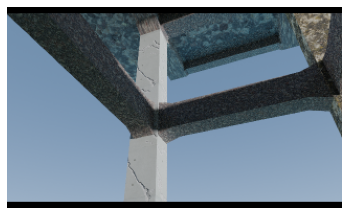

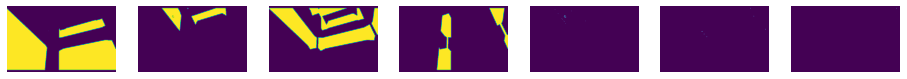

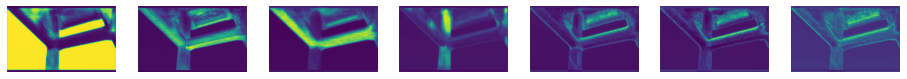

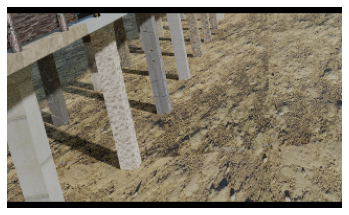

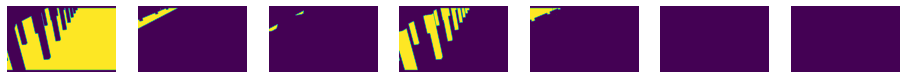

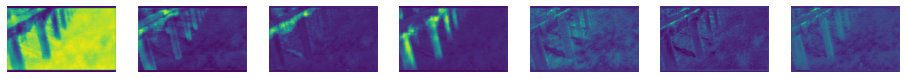

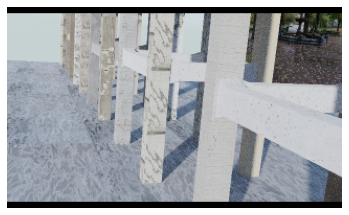

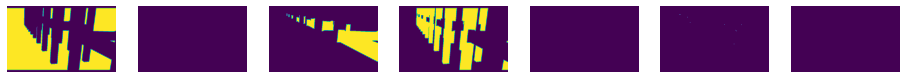

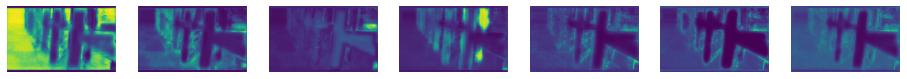

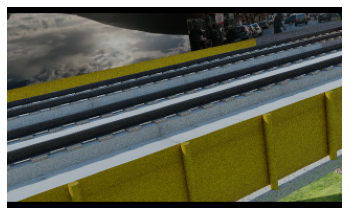

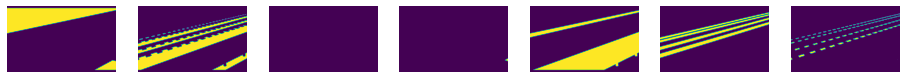

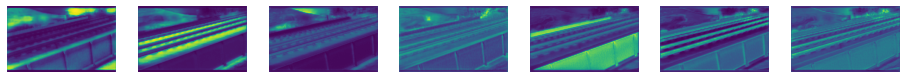

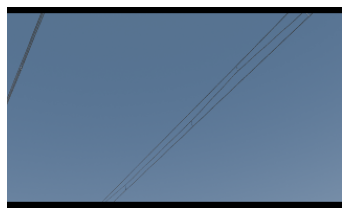

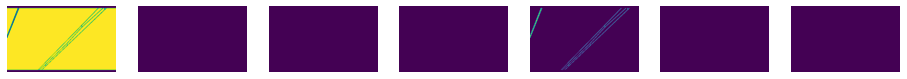

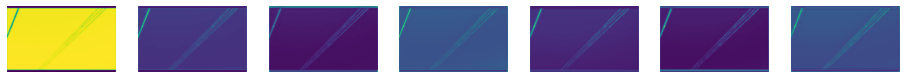

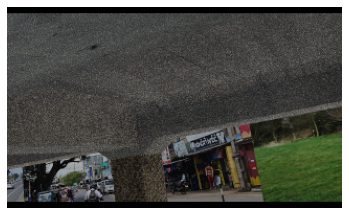

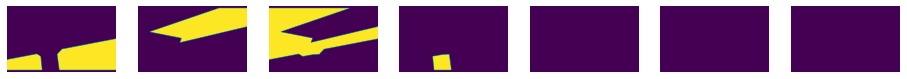

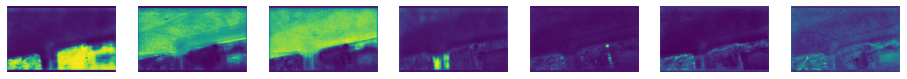

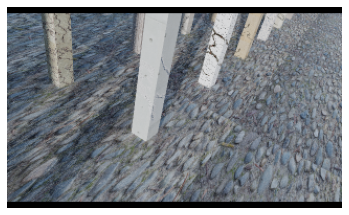

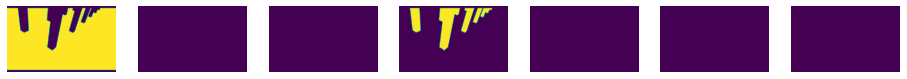

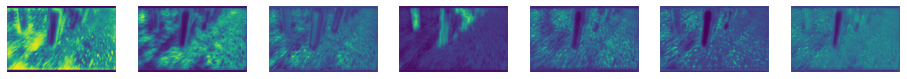

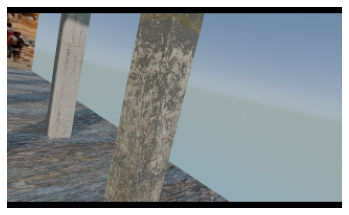

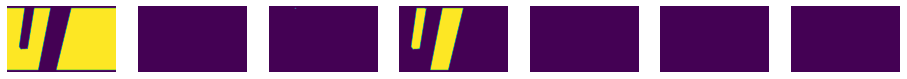

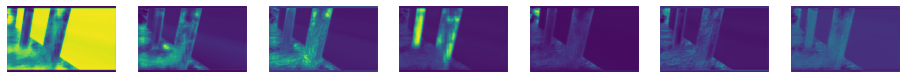

In [ ]:
#Printing predictions on the validation dataset
z=1
for x, y in dataset_val.take(10):
        z += 1
        show_img(x[1])
        show_label(y[1])
        pred = model.predict(x)
        show_pred(pred[1])
        if (z==9):
          break

###Checkpoint 5

In [ ]:
#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('/content/drive/MyDrive/IC-SHM 2021','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftest = pd.read_csv(os.path.join(path_ds,'files_test.csv'),names = col_names,delimiter=',')
ftest.iloc[:,0] = ftest.iloc[:,0].apply(lambda x: path_correct(x))
ftest.iloc[:,1] = ftest.iloc[:,1].apply(lambda x: path_correct(x))
ftest.iloc[:,2] = ftest.iloc[:,2].apply(lambda x: path_correct(x))
ftest.iloc[:,3] = ftest.iloc[:,3].apply(lambda x: path_correct(x))
test_comp = ftest.loc[ftest['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]

In [ ]:
#Preprocessing for the test dataset
def preprocess_test(x,y):
    def f(x,y):
        x = tf.io.read_file(x)
        y = tf.io.read_file(y)
        x = tf.io.decode_png(x, channels = 0)
        x = tf.image.resize_with_pad(x, 192,320)
        x = tf.numpy_function(normalize, [x], [tf.float32]) 
        y = tf.io.decode_bmp(y, channels = 0)   
        y = tf.numpy_function(get_label, [y], [tf.float32])
        y = tf.image.resize_with_pad(y, 192, 320)   

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([192, 320, 3])
    masks.set_shape([192, 320, 7])

    return images, masks

In [ ]:
def tf_dataset_test(x,y, batch = 8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess_test, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.batch(batch, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset

In [ ]:
images_test = test_comp['image file name'].to_numpy()
masks_test = test_comp['component label file name'].to_numpy()
dataset_test = tf_dataset_test(images_test, masks_test)
address = test_comp['component label file name'].apply(lambda x : os.path.split(x)[1]).to_numpy()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pypl

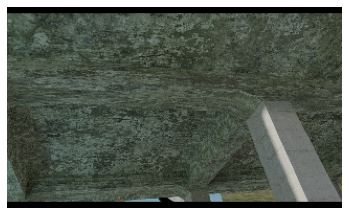

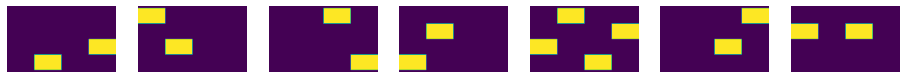

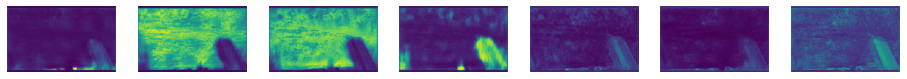

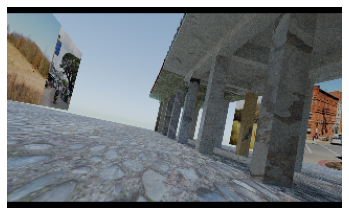

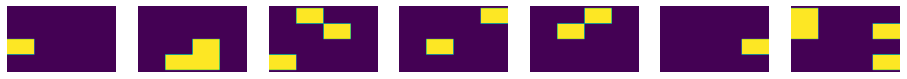

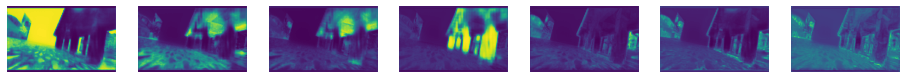

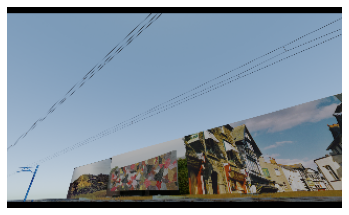

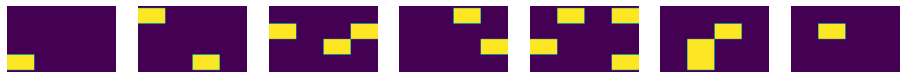

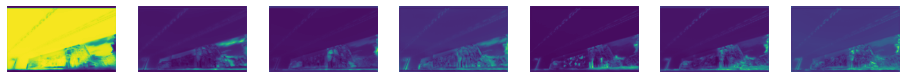

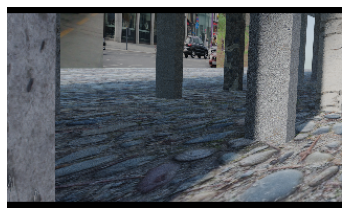

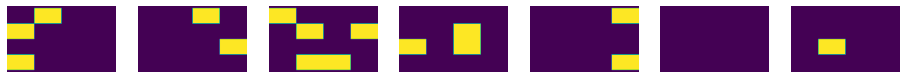

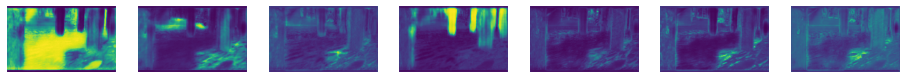

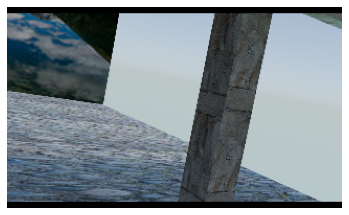

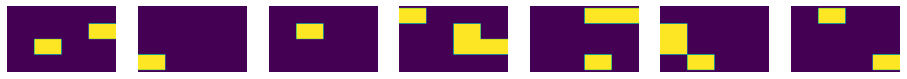

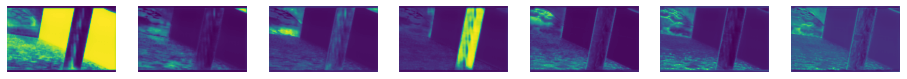

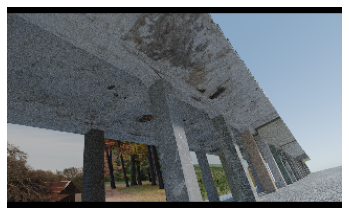

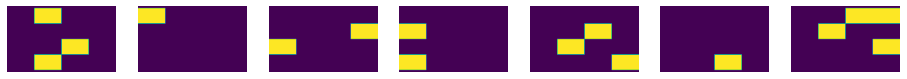

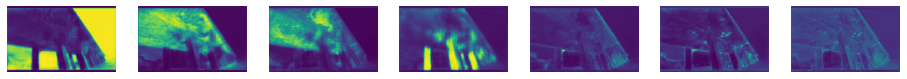

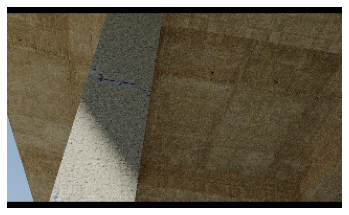

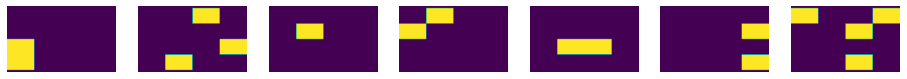

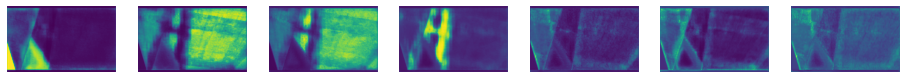

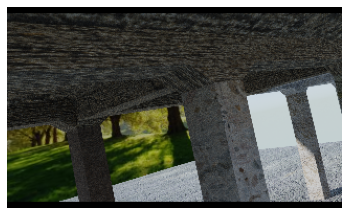

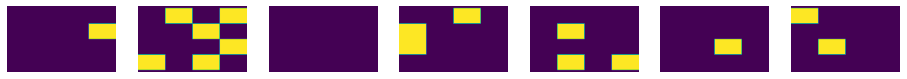

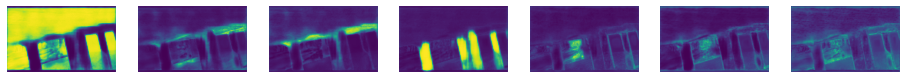

In [ ]:
#Printing the predictions for the test dataset
z=1
for x, y in dataset_test.take(10):
        z += 1
        show_img(x[0])
        show_label(y[2])
        pred = model.predict(x)
        show_pred(pred[0])
        if (z==9):
          break

###Checkpoint 6

In [ ]:
#Function to create the predictions and upscale them to size (360, 640) and then save in the drive folder
from PIL import Image
import imageio
import cv2

root_path = '/content/drive/MyDrive/summer_intern/Prediction_lab1' #Change the root folder as per the system

def size_changer(img):
  mask = np.zeros((360,640, img.shape[2]), dtype = np.uint8)
  for i in range(img.shape[2]):
    temp = np.where(img[:,:,i] > 0.6, 1, 0)
    temp = cv2.resize(temp.astype('uint8'), dsize = (640,360), interpolation=cv2.INTER_CUBIC)
    temp = np.where(temp > 0.6, 1, 0)
    mask[:,:,i] = temp
  return mask

def crop(img):
  image = img[6:186,:,:]
  return image

def mask_save(img, save_path):
  path = os.path.join(root_path, 'synthetic/test/labcmp') #Change this path as per system
  img = crop(img)
  img = size_changer(img)
  mask = img
  output = np.zeros((mask.shape[0],mask.shape[1]), dtype = np.uint8)
  output = np.argmax(mask, axis = 2)
  output = output + 1

  imageio.imwrite(os.path.join(path, save_path), output.astype('uint8'))

  return None

i = 0
for item in dataset_test:
  p = model.predict(item[0])
  for j in range(len(p)):
    mask_save(p[j], os.path.join(address[i]))
    i += 1
    print(i)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
#Function to change the path format 
def path_correct2(path):
  path = '/'.join(path[2:].split('\\'))
  return path

In [ ]:
#Function to change the path format 
def path_correct_png1(path):
  path = '/'.join(path[2:].split('\\'))
  path = path[:-4] + '.png'
  return path

In [ ]:
# -- coding: utf-8 --
"""
Created on Mon Aug 30 10:58:46 2021

@author: narazaki
"""

import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    # pixels= img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def preprocess(img,labels):
    img = np.array(img)
    lab_1hot = np.zeros((img.shape[0],img.shape[1],len(labels)),dtype=np.bool)
    for i in range(len(labels)):
        lab_1hot[:,:,i] = img==labels[i]
    return lab_1hot

def pred2kaggle(pred_path,csv_read,csv_write,im_col,lab_col,labels,select_col=None):
    # read a csv file associated with the testing data and create Kaggle solution csv file
    # im_col: csv column idx that points to image files
    # lab_col: csv column idx that points to label files
    # select_col: csv column idx that points to selected files (default:None)
    df = pd.read_csv(csv_read,header=None)
    #
    labFiles1 = list(df[lab_col])
    #
    for i in range(len(df)):
      df.iloc[i,im_col] = path_correct2(df.iloc[i,im_col])
      df.iloc[i,lab_col] = path_correct2(df.iloc[i,lab_col])
      
    labFiles = list(df[lab_col])
    imFiles = list(df[im_col])
    if select_col is not None:
        imFiles = [imFiles[i] for i in range(len(imFiles)) if df[select_col][i]]
        labFiles = [labFiles[i] for i in range(len(labFiles)) if df[select_col][i]]
        labFiles1 = [labFiles1[i] for i in range(len(labFiles1)) if df[select_col][i]]
    
    data = pd.DataFrame()
    for i in range(len(imFiles)):
        m = preprocess(Image.open(os.path.join(pred_path,labFiles[i])),labels)
        for j in range(len(labels)):
            name = labFiles1[i][:-4]+'_'+str(labels[j])

            temp = pd.DataFrame.from_records([
                        {
                            'ImageId': name,
                            'EncodedPixels': mask2rle(m[:,:,j]),  
                        }]
                    )
            data = pd.concat([data, temp],ignore_index=True)
        print(i)
    if csv_write is not None:
        data.to_csv(csv_write, index=False)
    return data

if __name__ == '__main__':
    pred_path = os.path.join('/content/drive/MyDrive/summer_intern', 'Prediction_lab1') #path to the folder that contains predicted masks
    csv_path = '/content/drive/MyDrive/IC-SHM 2021/Tokaido_dataset' #path to the Tokaido Dataset folder
    
    
    # component labels
    csv_read = os.path.join(csv_path,'files_test.csv')
    im_col = 0
    lab_col = 1
    select_col = 5
    csv_write = 'component_submission_sample.csv'
    labels = [2,3,4,5,6,7]
    pred2kaggle(pred_path,csv_read,csv_write,im_col,lab_col,labels,select_col)
    '''
    # damage labels (viaduct images)
    csv_read = os.path.join(csv_path,'files_test.csv')
    im_col = 0
    lab_col = 2
    select_col = 6
    labels = [2,3]
    df0 = pred2kaggle(pred_path,csv_read,None,im_col,lab_col,labels,select_col)
    
    # damage labels (pure texture images)
    csv_read = os.path.join(csv_path,'files_puretex_test.csv')
    im_col = 0
    lab_col = 1
    select_col = None
    labels = [2,3]
    df1 = pred2kaggle(pred_path,csv_read,None,im_col,lab_col,labels,select_col)
    
    #write damage solution csv file
    df = pd.concat([df0, df1],ignore_index=True)
    csv_write = 'damage_submission_sample.csv'
    df.to_csv(csv_write, index=False)'''

###Checkpoint 7

In [ ]:
#Checking the saved predictions
print(address[0])
image = mpimg.imread(os.path.join('/content/drive/MyDrive/summer_intern/Prediction_lab1/synthetic/test/labcmp' ,address[5]))
plt.imshow(image)

In [ ]:
#Original image file of the saved prediction
image2 = mpimg.imread(os.path.join('/content/drive/MyDrive/IC-SHM 2021/Tokaido_dataset' ,test_comp['image file name'].iloc[5]))
plt.imshow(image2)

In [ ]:
#Code to find th weights needed for the weighted loss function
import skimage.io
p_of_class_1_pix=0
p_of_class_2_pix=0
p_of_class_3_pix=0
p_of_class_4_pix=0
p_of_class_5_pix=0
p_of_class_6_pix=0
p_of_class_7_pix=0
p_of_class_8_pix=0
for i in range(7575):
  img = skimage.io.imread(masks[i])

  # counting the number of pixels
  p_of_class_1_pix = p_of_class_1_pix+((np.sum(img == 1)/(360*640)))
  p_of_class_2_pix = p_of_class_2_pix+((np.sum(img == 2)/(360*640)))
  p_of_class_3_pix = p_of_class_3_pix+((np.sum(img == 3)/(360*640)))
  p_of_class_4_pix = p_of_class_4_pix+((np.sum(img == 4)/(360*640)))
  p_of_class_5_pix = p_of_class_5_pix+((np.sum(img == 5)/(360*640)))
  p_of_class_6_pix = p_of_class_6_pix+((np.sum(img == 6)/(360*640)))
  p_of_class_7_pix = p_of_class_7_pix+((np.sum(img == 7)/(360*640)))
  p_of_class_8_pix = p_of_class_8_pix+((np.sum(img == 8)/(360*640)))

p_of_class_1_pix=p_of_class_1_pix/75.75
p_of_class_2_pix=p_of_class_2_pix/75.75
p_of_class_3_pix=p_of_class_3_pix/75.75
p_of_class_4_pix=p_of_class_4_pix/75.75
p_of_class_5_pix=p_of_class_5_pix/75.75
p_of_class_6_pix=p_of_class_6_pix/75.75
p_of_class_7_pix=p_of_class_7_pix/75.75
p_of_class_8_pix=p_of_class_8_pix/75.75

print('percentage of class 1 pixels:', p_of_class_1_pix)
print('percentage of class 2 pixels:', p_of_class_2_pix)
print('percentage of class 3 pixels:', p_of_class_3_pix)
print('percentage of class 4 pixels:', p_of_class_4_pix)
print('percentage of class 5 pixels:', p_of_class_5_pix)
print('percentage of class 6 pixels:', p_of_class_6_pix)
print('percentage of class 7 pixels:', p_of_class_7_pix)
print('percentage of class 8 pixels:', p_of_class_8_pix)

In [ ]:
# # Custom Conv blocks for the unet 2
# def conv_1(input, num_filters):
#   x = Conv2D(num_filters, 3, padding="same")(input)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   x = Conv2D(num_filters, 3, padding="same")(x)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   return x

# def conv_2(input, num_filters):
#   x = Conv2D(num_filters, 5, padding="same", dilation_rate = 2)(input)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   x = Conv2D(num_filters, 3, padding="same")(x)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   x = Conv2D(num_filters, 3, padding="same", dilation_rate = 3)(x)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   x = Conv2D(num_filters, 3, padding="same")(x)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   return x

# #Additional conv layers for 

# def conv_3(input, num_filters):

#   x = Conv2D(num_filters, 3, padding="same")(input)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   x = Conv2D(num_filters, 5, padding="same", dilation_rate = 2)(x)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   x = Conv2D(num_filters, 3, padding="same", dilation_rate = 2)(x)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   x = Conv2D(num_filters, 3, padding="same")(x)
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   return x

# def conv_starter(input, num_filters):
#   x2 = Conv2D(num_filters, 5, padding="same")(input)
#   x2 = BatchNormalization()(x2)
#   x3 = Conv2D(num_filters, 3, padding="same", dilation_rate = 2)(input)
#   x3 = BatchNormalization()(x3)
#   x5 = Conv2D(num_filters, 3, padding="same")(input)
#   x5 = BatchNormalization()(x5)
#   x = Add()([x2, x3, x5])
#   x = BatchNormalization()(x)
#   x = Activation("relu")(x)

#   return x

# def conv_block1(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x

# # Custom Encoder blocks for Unet2
# def encoder_1(input, num_filters):
#   x = conv_1(input, num_filters)
#   p = MaxPool2D((2,2))(x)
#   return x, p

# def encoder_2(input, num_filters):
#   x = conv_2(input, num_filters)
#   x = conv_3(x, num_filters)
#   p = MaxPool2D((2,2))(x)
#   return x, p

# # Decoder blocks for unet2
# def decoder_block1(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block1(x, num_filters)
#     return x

# def decoder_block2(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="valid")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block1(x, num_filters)
#     return x

# def build_unet(input_shape):
#   inputs = Input(input_shape)

#   s = conv_starter(inputs, 64)

#   s1, p1 = encoder_2(s, 64)
#   s2, p2 = encoder_1(p1, 128)

#   b1 = conv_3(p2, 256)
#   b2 = conv_2(b1, 512)
#   b3 = conv_2(b2, 1024)
#   b4 = conv_1(b3, 512)
#   b5 = conv_1(b4, 256)

#   d4 = decoder_block1(b5, s2, 128)
#   d5 = decoder_block1(d4, s1, 64)

#   outputs = Conv2D(7, 1, padding="same", activation="sigmoid")(d5)

#   model = Model(inputs, outputs, name="U-Net")
#   return model